# Preamble

In [9]:
%run -i scripts/preamble.py

### Data Download - Preferred, fully replicable to the below

> __Note__: Due to submission size limitations, the datasets were __not__ included in the repost submission. Instead, I have made them publicly downloadable from S3.

The preferred method to retrieve the data is to run `dvc pull` in the CLI. This will ensure that the exact same samples are retrieved to the ones used in the report. See documentation for [DVC](https://dvc.org/doc/command-reference/pull) for reference. This depends on installing `dvc` and `dvc-s3` in the environment.

### Data Download - Alternative

Run the following line once in order to retrieve the data samples from AWS S3. Below, we pass 100000 as the sample argument. Before doing so, please ensure that `boto3` and `s3fs` are installed. Refer to `requirements.txt` for further dependencies.
```{python}
%run scripts/s3_data_retrieval/retrieve_samples_from_s3.py 100000
```

# Introduction

The global digital advertising market is worth approximately $602 billion today. Due to the increasing rate of of online participation since the COVID-19 pandemic, this number has been rapidly increasing and is expected to reach $871 billion by the end of 2027 ([eMarketer, 2024](#eMarketer)). Many of the of the major Ad platforms such as Google, Facebook and Amazon operate on a cost-per-user-engagement pricing model, which usually means that advertisers get charged for every time a user clicks on an advertisment. This means that these platforms are incentivized to make sure that the content shown to each user is as relevent as possible in order to maximize the number of clicks in the long term. Attaining accurate Click-Through Rate (CTR) prediction is a necessary first step for Ad persionalization, which is why study of CTR prediction methods have been an extremely active part of Machine Learning research over the past through years.

Initially, shallow prediction methods such as XGBoost (Cite), Factorization Machines (Cite) and Field-Aware Factorization Machines (Cite) have been used for CTR prediction. However, these methods have often been shown to be unable to capture the higher order feature interactions in the sparse multy value categorical Ad Marketplace datasets (Cite). Since then, Deep Learning methods have been shown to show superior predictive ability on these datasets. The focus of my reasearch project is therefore to explore the merits of different Deep Learning architechtures for click-through rate prediction

In the following report, I explore the relevant datasets and simulations that I will be using throughout my research project. In the first section, I perform an exploratory data analysis on three widely adopted benchmark CTR prediction datasets; the KDD12 ([Aden, 2012](#kdd12)), Avazu ([Wang and Cukierski, 2014](#avazu)) and Criteo ([Tien et al, 2014](#criteo)) datasets. In the second section, I then explore possible ways of simulating the ad marketplace environment in order to test the reinforcement learning framework.

# Data Analysis and Pre-processing

I begin below by first introducting the three datasets widely used as benchmarks in CTR prediction research.

### KDD12

The __KDD12__ dataset was first released for the KDD Cup 2012 competition (Cite), with the original task being to predict the number of clicks for a given number of impressions. Each line represents a training instance derived from the session logs for the advertizing marketplace. In the context of this dataset, a "session" refers to an interaction between a user and the search engine, containing the following components; the user, a list of adverts returned by the search engine and shown (impressed) to the user and zero or more adverts clicked on by the user. Each line in the training set includes:

- __Click and Impression counts__: The click counts were the original target variable when the dataset was first released for the competition. As done in (Cite Song and Others), this dataset can be adapted to CTR prediction by simply calculating the CTR for each instance by dividing the Click counts by the Impression counts.
- __Session features__: These include _session depth_ (the number of ads impressed in a session) as well as the tokenized query phrase that the user entered into the search engine.
- __User features__: Encoded gender and age group for the user, if known.
- __Ad features__: Display URL, ad ID, advertiser ID and encoded title, description and purchased key words.

In [2]:
%run -i scripts/data_analysis_and_preprocessing/retrieve_kdd12.py

Snapshot of KDD12 training data:


,Click,Impression,DisplayURL,AdID,AdvertiserID,Depth,Position,QueryID,KeywordID,TitleID,DescriptionID,UserID
0,0,1,12057878999086460853,20157098,27961,1,1,75606,15055,12391,13532,1350148
1,0,1,12057878999086460853,20221208,27961,2,1,2977,1278,3054,4561,1350148
2,0,1,12057878999086460853,20183701,27961,1,1,18594855,227,543,642,1350148
3,0,1,12057878999086460853,20183690,27961,1,1,4260473,34048,175983,155050,1350148
4,0,1,3029113635936639912,10397010,24973,2,2,2977,1274,2570,26091,1350148


### Avazu

The __Avazu__ dataset was originally released in 2014 for a CTR prediction Competition on Kaggle (Cite Avazu). The data is composed of 11 days worth mobile ad marketplace data. Much like the KDD12 dataset above, this dataset contains features ranging from user activity (clicks), user identification (device type, IP) to ad features. Notible differences to the KDD12 dataset include the fact that Avazu contains an "hour" feature (enabling the establishment of sequentiality of behaviours) and the fact that Avazu does not seem to contain query and ad texts.

In [3]:
%run -i scripts/data_analysis_and_preprocessing/retrieve_avazu.py

Snapshot of Avazu training data:


,id,click,hour,c1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,c14,c15,c16,c17,c18,c19,c20,c21
0,15674134821169810910,1,14102300,1005,0,85f751fd,c4e18dd6,50e219e0,e71aba61,2347f47a,...,1,0,21676,320,50,2495,2,167,-1,23
1,15674278914362889244,0,14102300,1005,0,85f751fd,c4e18dd6,50e219e0,6f8bcb0f,2347f47a,...,1,0,20476,320,50,2348,3,427,100005,61
2,1567455966106046075,0,14102300,1005,0,26fa1946,e2a5dc06,3e814130,ecad2386,7801e8d9,...,1,0,20362,320,50,2333,0,39,-1,157
3,15674616734887926359,0,14102300,1005,0,85f751fd,c4e18dd6,50e219e0,53de0284,d9b5648e,...,1,0,21611,320,50,2480,3,297,100111,61
4,15674670592044781339,0,14102300,1005,0,85f751fd,c4e18dd6,50e219e0,a0fc55e5,2347f47a,...,1,0,20361,300,250,2333,0,39,-1,157


### Criteo

Finally, the Criteo dataset is another benchmark CTR prediction dataset that was originally released on Kaggle for a CTR prediction compitition. The original dataset is made up of 45 Million user's click activity, and contains the click/no-click target along with 26 categorical feature fields and 13 numerical feature fields. Unlike the other two datasets however, the semintic significance of these fields is not given - they are simply labelled as "Categorical 1-26" and "Numerical 1-13" respectively.

In [4]:
%run -i scripts/data_analysis_and_preprocessing/retrieve_criteo.py

Snapshot of Criteo training data:


,click,int_1,int_2,int_3,int_4,int_5,int_6,int_7,int_8,int_9,...,cat_17,cat_18,cat_19,cat_20,cat_21,cat_22,cat_23,cat_24,cat_25,cat_26
0,0,NaN,1,2.0,5.0,27586.0,32.0,2.0,14.0,21.0,...,07c540c4,bdc06043,NaN,NaN,6dfd157c,NaN,32c7478e,ef089725,NaN,NaN
1,1,14.0,1,1.0,8.0,276.0,14.0,41.0,9.0,10.0,...,e5ba7672,87c6f83c,NaN,NaN,0429f84b,NaN,be7c41b4,c0d61a5c,NaN,NaN
2,0,NaN,1,27.0,25.0,NaN,NaN,0.0,54.0,55.0,...,2005abd1,87c6f83c,NaN,NaN,15fce809,NaN,be7c41b4,f96a556f,NaN,NaN
3,0,0.0,442,1.0,1.0,3029.0,58.0,2.0,13.0,44.0,...,d4bb7bd8,cdfa8259,NaN,NaN,20062612,NaN,dbb486d7,1b256e61,NaN,NaN
4,0,0.0,-1,2.0,1.0,1167.0,88.0,23.0,19.0,673.0,...,27c07bd6,5bb2ec8e,49b8041f,b1252a9d,bff87997,NaN,32c7478e,3fdb382b,f0f449dd,49d68486


### Target Variable Analysis

The figure below shows that the three datasets have vastly different average Click Through Rates per instance. The average CTR for the KDD12 dataset is only 3.4%, whereas the Criteo dataset is 25.6%.

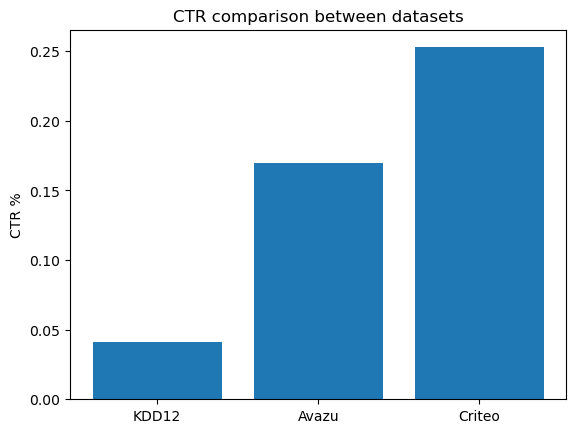

In [5]:
%run -i scripts/data_analysis_and_preprocessing/ctr_bar_charts.py

### Missingness and Data Imputation

Below, I take a look at whether or not our dataset has any missing values. 

Missingness matrix for Criteo dataset:


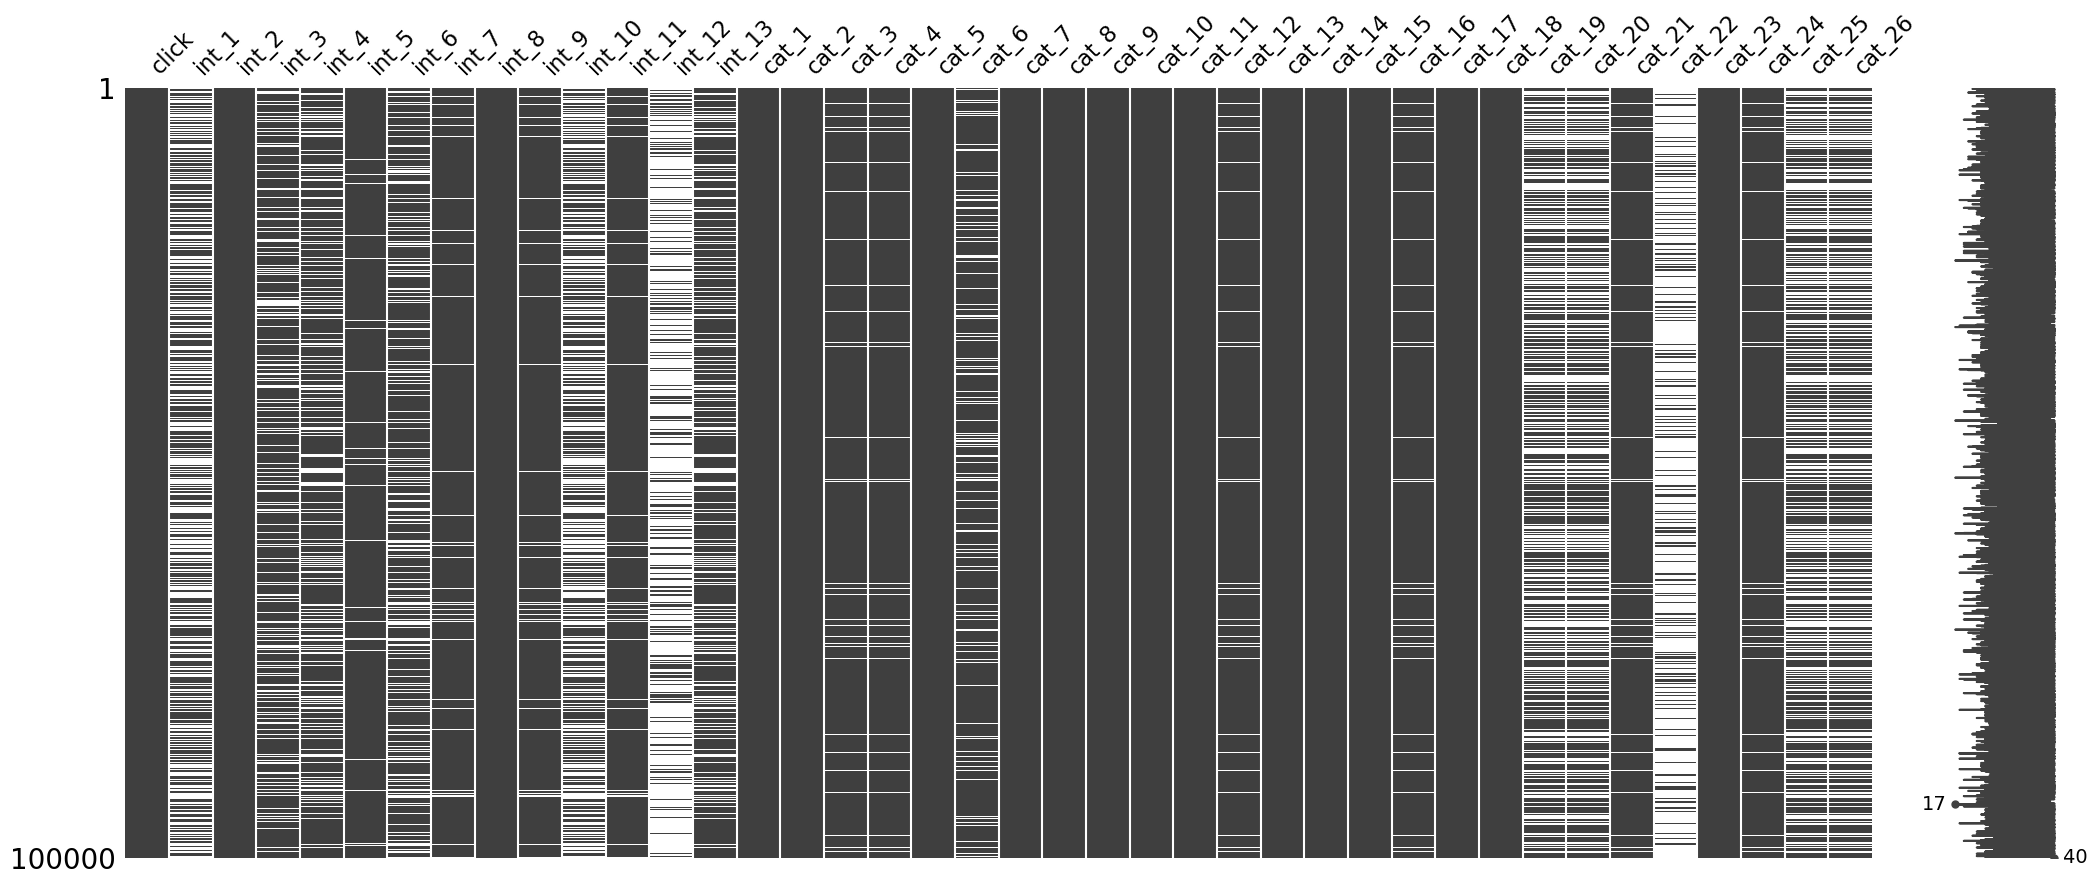

In [6]:
# Show missingness matrix for criteo dataset
print("Missingness matrix for Criteo dataset:")
msno.matrix(criteo)
plt.show()

Above we see that Criteo has some missing values. Below I proceed by imputing the missing values using Sklearn's KNN Imputer. The code for these imputations does not get executed here.

Imputation steps taken were:

1. Factorize categorical values in the dataset, converting them to integers. This was done because sklearn's imputers only work with numerical data.
2. Use the sklearn's [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html) with [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) to impute the missing values. This was recommended in [this github discussion](https://github.com/scikit-learn/scikit-learn/discussions/28545) for imputing data with categorical values.
3. Concatinate missingness indicators to the dataset as additional features, as recommended by [Van Buuren (2018)](#vanBuuren)

The script for the above is in [scripts/data_analysis_and_processing/impute_criteo_nulls.py]().

In [7]:
# Pick up the imputed dataset
criteo_imputed_inds = pd.read_csv('./data/criteo/criteo_train_imputed.csv').astype('int')
criteo_imputed_inds[criteo.columns[criteo.dtypes == 'category']] = criteo_imputed_inds[criteo.columns[criteo.dtypes == 'category']].clip(lower=0,upper=None)

### Sparse Multi-Value Categorical Features

As already mentioned above, ad marketplace data often contains sparse categorical features, which make signal detection extremely difficult in shallow modelling frameworks. Below I show examples from each dataset

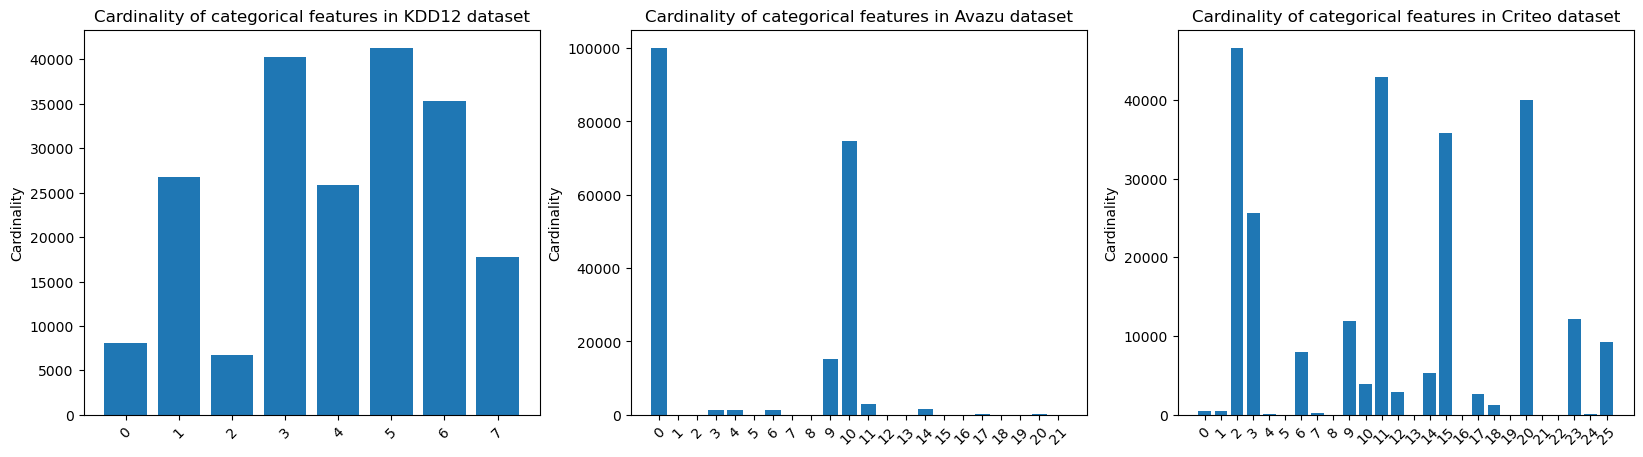

In [11]:
%run -i scripts/data_analysis_and_preprocessing/plot_cardinalities.py

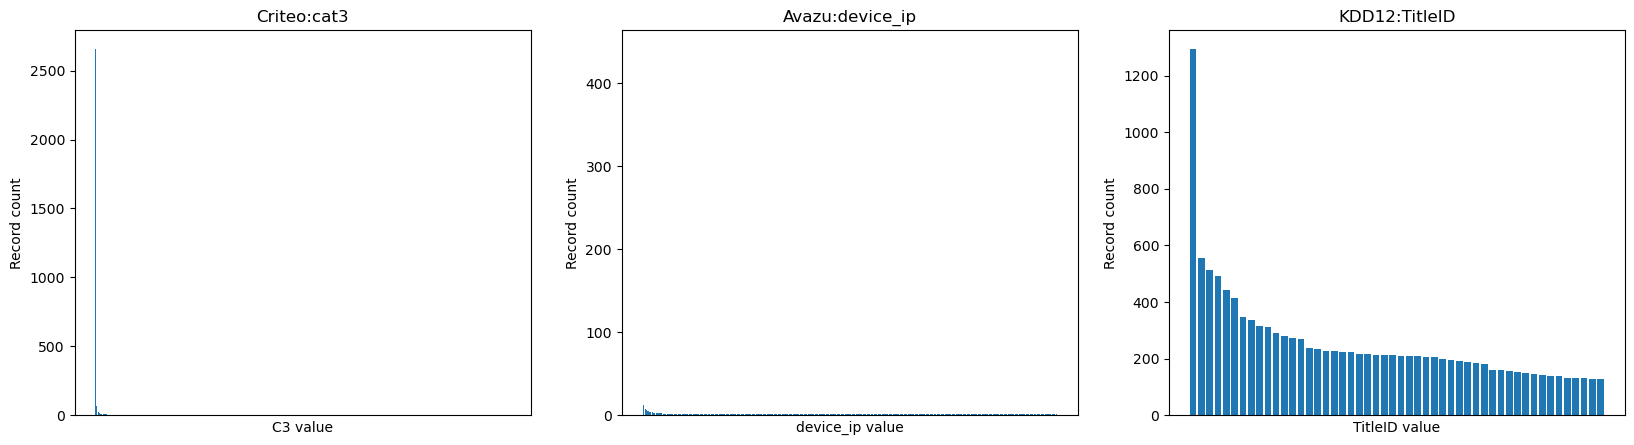

In [12]:
%run -i scripts/data_analysis_and_preprocessing/plot_high_cardinality_record_counts.py

A common remidy to the above issue is to _bin_ the categorical feature values before one-hot encoding or embedding, according to some given threshold (Cite Song, Others). This essentially means that for a given threshold $t$, we retain only the values for the multi-value categorical features that have more than $t$ occurances in the dataset. (Cite Song) Reccomends usign, setting $t = {10,5,10}$ for Criteo, KDD12 and Avazu respectively. Due to computational limitations, this was multiplied by a factor of 100

In [13]:
%run -i scripts/data_analysis_and_preprocessing/binned_OH_encoding.py

Before one-hot encoding:
KDD12 shape: (100000, 12)
Avazu shape: (100000, 24)
Criteo shape: (100000, 64)

After one-hot encoding:
KDD12 shape: (100000, 12)
Avazu shape: (100000, 24)
Criteo shape: (100000, 64)
Sparse output:
KDD12 shape: (100000, 1478)
Avazu shape: (100000, 924)
Criteo shape: (100000, 2003)


### High Variance Numerical outliers

Below I check the distributions of the numerical features in the datasets

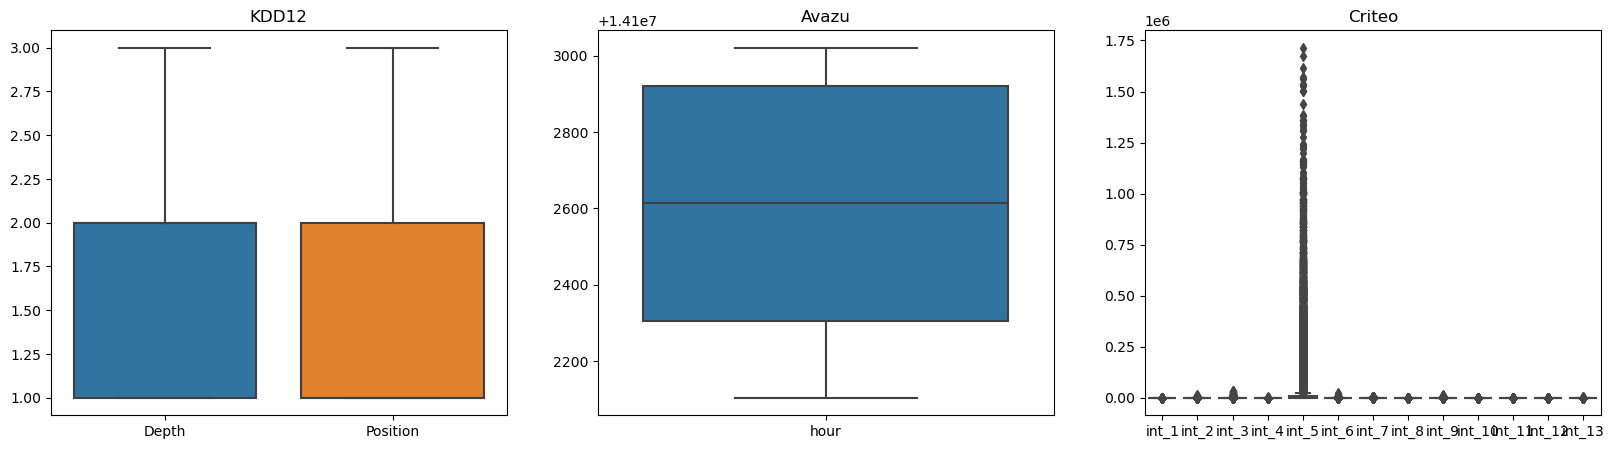

In [15]:
%run -i scripts/data_analysis_and_preprocessing/plot_numerical_distributions.py

Due to the high variance of numerical features in the Criteo dataset, it is necessary to transform these variable in order to ease the training of deep NN's. As done be (Cite Song and Wang, and the winner of the Criteo Competition), we will proceed by applying the transform $\log^2 (z)$ if $z>2$, and where $z$ is the standardized numerical value.

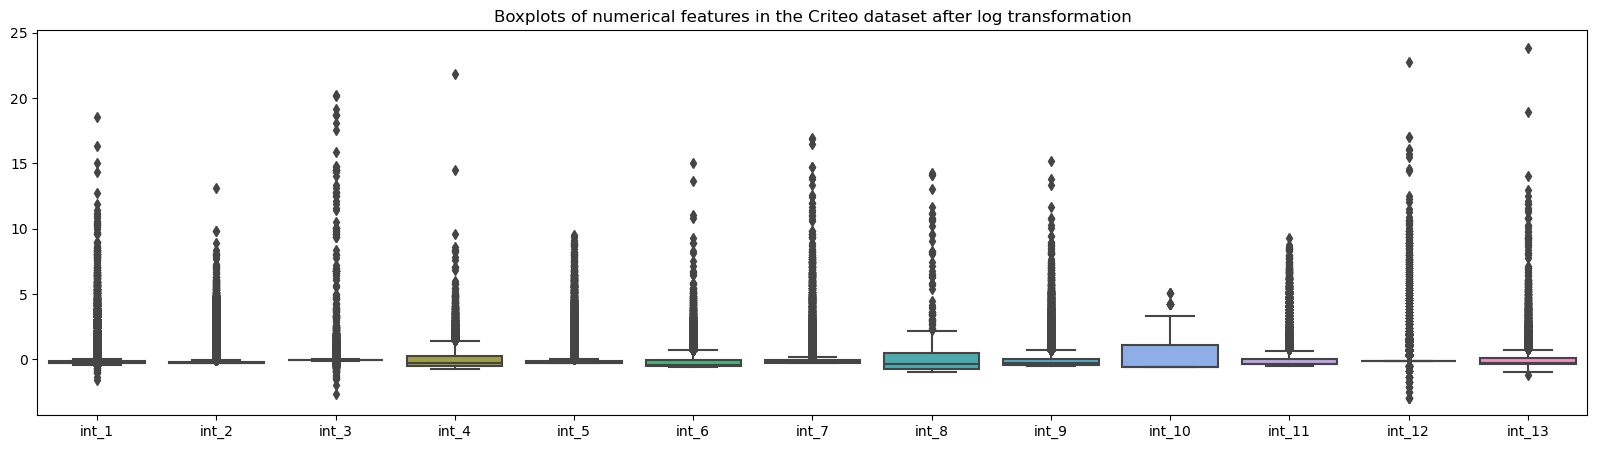

In [16]:
%run -i scripts/data_analysis_and_preprocessing/numerical_standardization.py

In [17]:
%run -i scripts/data_analysis_and_preprocessing/export_preprocessed.py

### Correlation Analysis

Below I conduct a correlation analysis of the features to the Click-Through rate

In [21]:
# Replace the numerical values in the sparse datasets with the standardized values
kdd12_sparse[kdd12_numerical_columns] = kdd12_standardized[kdd12_numerical_columns]
avazu_sparse[avazu_numerical_columns] = avazu_standardized[avazu_numerical_columns]
criteo_sparse[criteo_numerical_columns] = criteo_standardized[criteo_numerical_columns]

In [22]:
# Compute the correlation matrix for the three datasets
kdd12_corr = kdd12_sparse.corr()
avazu_corr = avazu_sparse.corr()
criteo_corr = criteo_sparse.corr()

In [118]:
# Zero out the diagonal of the correlation matrices
np.fill_diagonal(kdd12_corr.values, 0)
np.fill_diagonal(avazu_corr.values, 0)
np.fill_diagonal(criteo_corr.values, 0)

C:\Users\marti\AppData\Local\Temp\ipykernel_14764\1548746507.py:6: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  mask[0] = True # Keep the click column


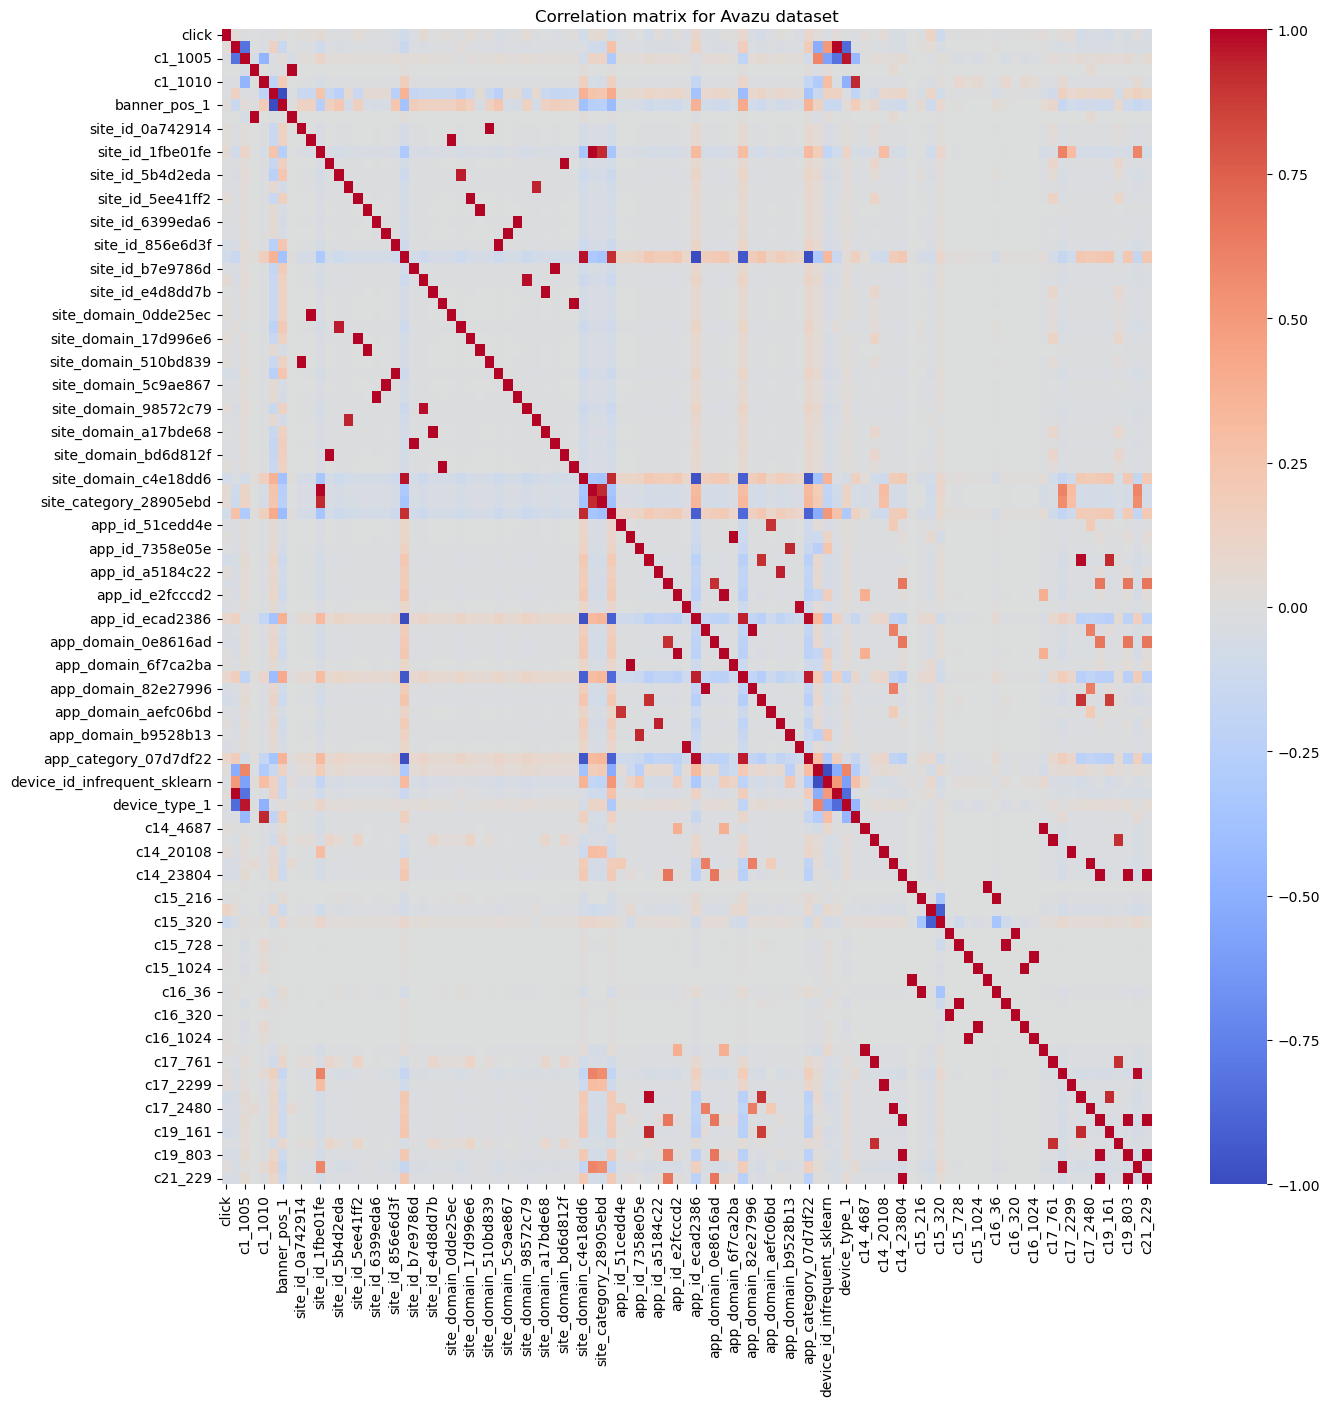

C:\Users\marti\AppData\Local\Temp\ipykernel_14764\1548746507.py:18: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  mask[0] = True # Keep the click column
C:\Users\marti\AppData\Local\Temp\ipykernel_14764\1548746507.py:23: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  mask[0] = True # Keep the click column


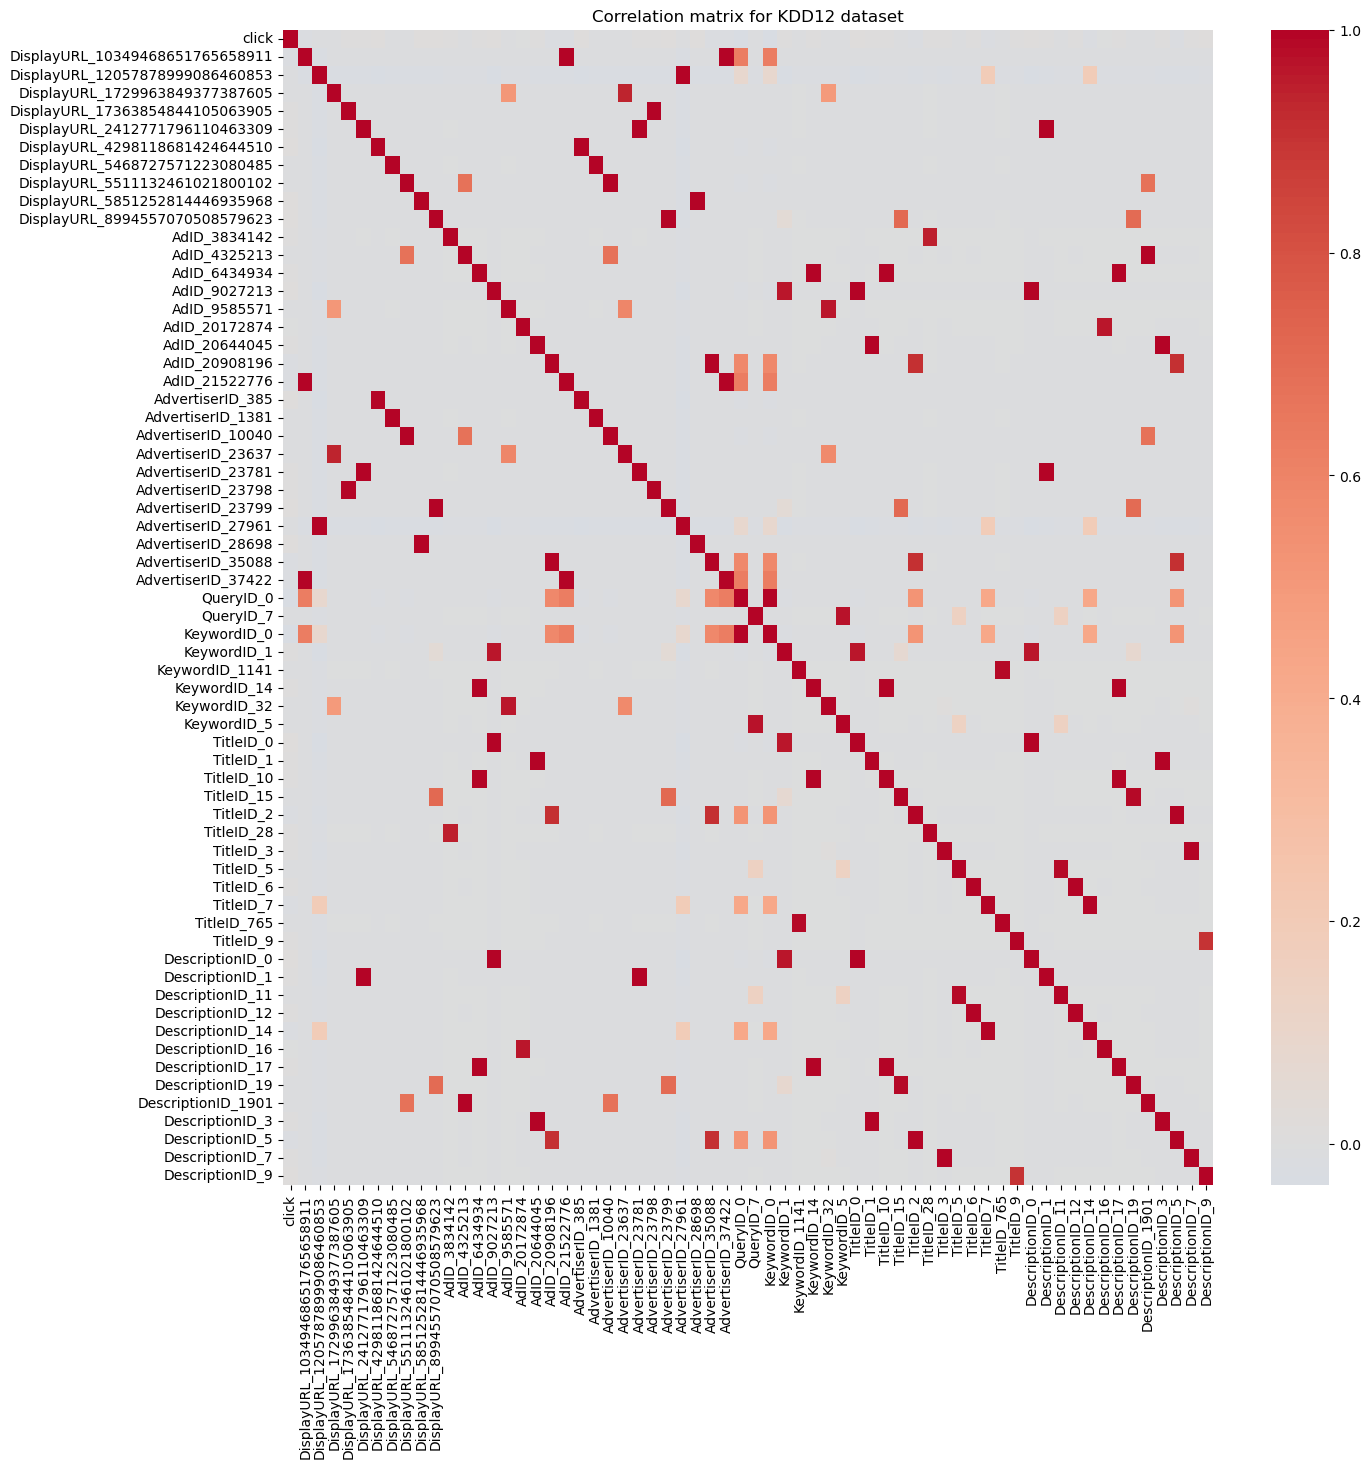

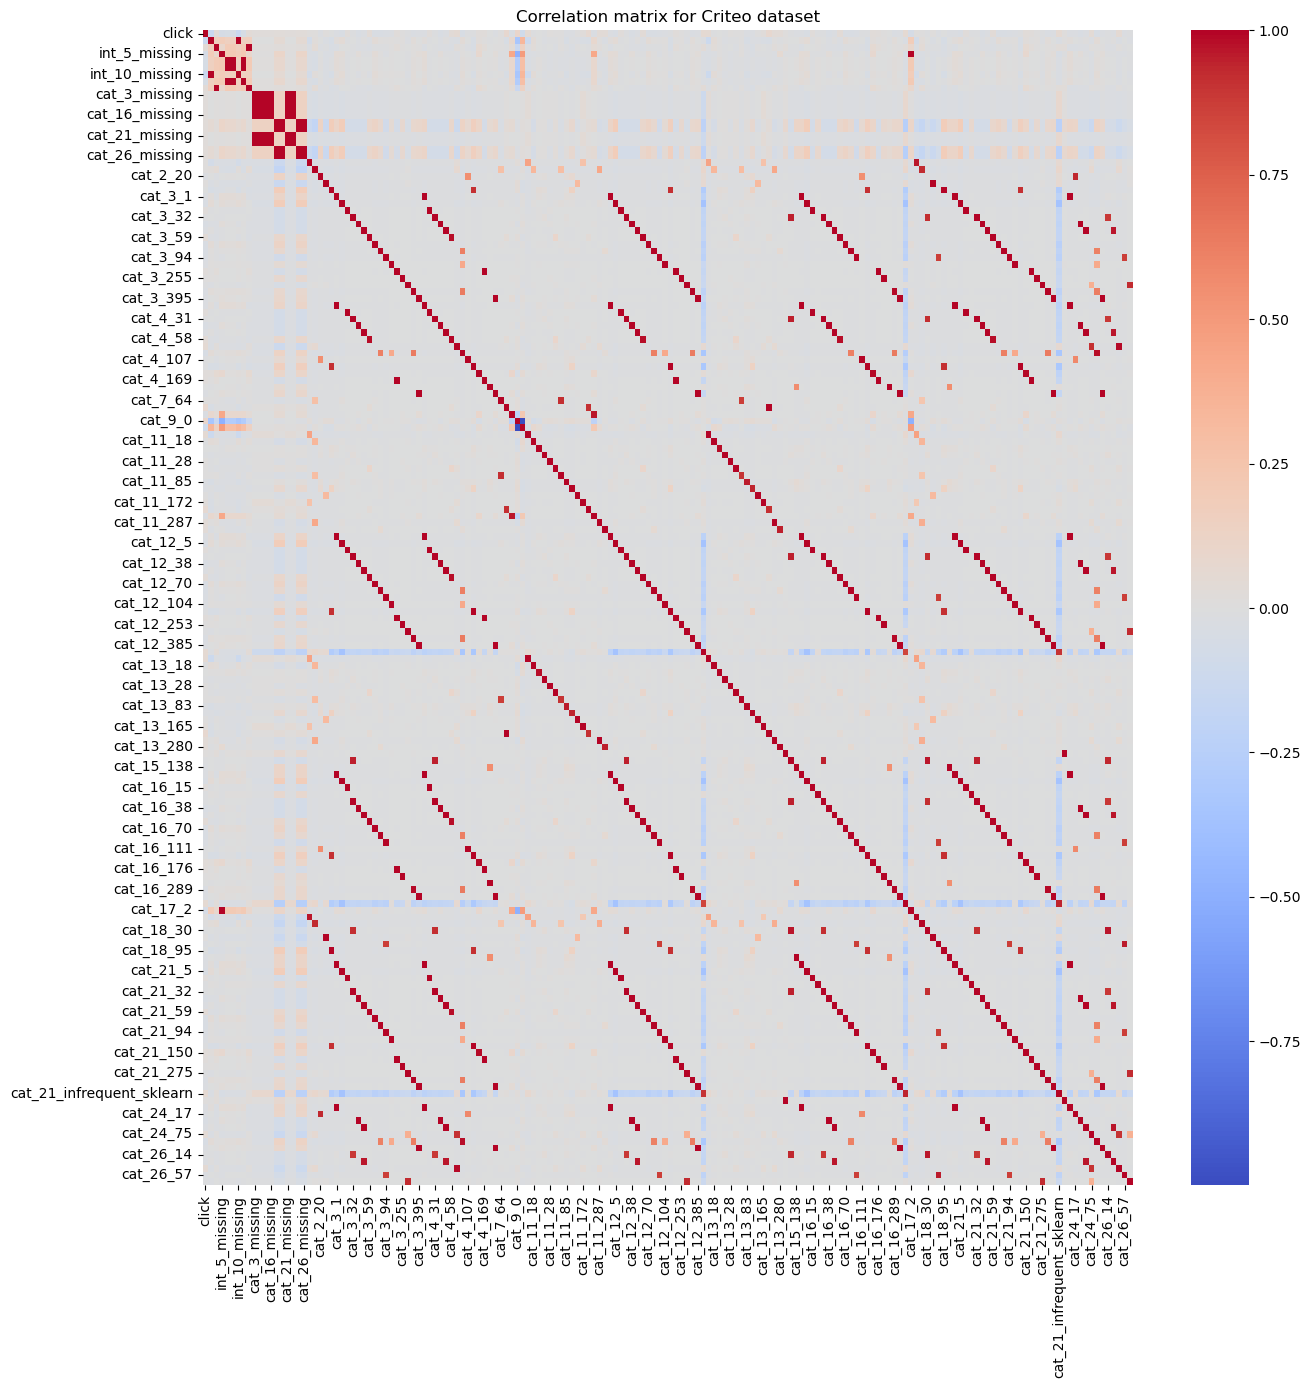

In [119]:
# Set the correlation threshold
corr_threshold = 0.9

# Filter out relevant values
mask = np.any(np.abs(avazu_corr) > corr_threshold, axis = 0)
mask[0] = True # Keep the click column
avazu_corr_filtered = avazu_corr.loc[mask, :].loc[:, mask]
np.fill_diagonal(avazu_corr_filtered.values, 1)

# Plot the correlation matrix for Avazu using seaborn
plt.figure(figsize=(15,15))
sns.heatmap(avazu_corr_filtered, cmap='coolwarm', center=0)
plt.title('Correlation matrix for Avazu dataset')
plt.show()

# Replicate the above for the KDD12 and Criteo datasets
mask = np.any(np.abs(kdd12_corr) > corr_threshold, axis = 0)
mask[0] = True # Keep the click column
kdd12_corr_filtered = kdd12_corr.loc[mask, :].loc[:, mask]
np.fill_diagonal(kdd12_corr_filtered.values, 1)

mask = np.any(np.abs(criteo_corr) > corr_threshold, axis = 0)
mask[0] = True # Keep the click column
criteo_corr_filtered = criteo_corr.loc[mask, :].loc[:, mask]
np.fill_diagonal(criteo_corr_filtered.values, 1)

# Plot the correlation matrix for KDD12 using seaborn
plt.figure(figsize=(15,15))
sns.heatmap(kdd12_corr_filtered, cmap='coolwarm', center=0)
plt.title('Correlation matrix for KDD12 dataset')
plt.show()

# Plot the correlation matrix for Criteo using seaborn
plt.figure(figsize=(15,15))
sns.heatmap(criteo_corr_filtered, cmap='coolwarm', center=0)
plt.title('Correlation matrix for Criteo dataset')
plt.show()

Some very high correlations between some of the features across fields in all three datasets. This possibly points to there being potential for dimensionality reduction across this feature set.

Unfortunately, from the correlation heatmaps, there appears to be little to no correlation between the first-order features and the target click variable.

# Modelling

In this section I will compare the perfomance of two shallow modelling approaches (Logistic Regression and Factorization Machines) to a naive DNN for CTR prediction. As with (Cite Song and Wang), I will use the __Area Under the ROC Curve__ and __Logloss__ measures to compare the performance of the different modelling approaches on the test set.

In [9]:
# Read in the encoded and standardized datasets
kdd12_standardized = pd.read_csv('./data/kdd12/kdd12_standardized.csv')
avazu_standardized = pd.read_csv('./data/avazu/avazu_standardized.csv').drop(columns=['id'])
criteo_standardized = pd.read_csv('./data/criteo/criteo_standardized.csv')

## Create lists of categorical colums for each dataset
kdd12_categorical_columns = [
    'DisplayURL',
    'AdID',
    'AdvertiserID',
    'QueryID',
    'KeywordID',
    'TitleID',
    'DescriptionID',
    'UserID'
]

avazu_categorical_columns = [
    'c1',
    'banner_pos',
    'site_id',
    'site_domain',
    'site_category',
    'app_id',
    'app_domain',
    'app_category',
    'device_id',
    'device_ip',
    'device_model',
    'device_type',
    'device_conn_type',
    'c14',
    'c15',
    'c16',
    'c17',
    'c18',
    'c19',
    'c20',
    'c21'
]

criteo_categorical_columns = [f'cat_{i}' for i in np.arange(1,27)]

## Cast categorical columns to string
kdd12_standardized[kdd12_categorical_columns] = kdd12_standardized[kdd12_categorical_columns].astype(str)
avazu_standardized[avazu_categorical_columns] = avazu_standardized[avazu_categorical_columns].astype(str)
criteo_standardized[criteo_categorical_columns] = criteo_standardized[criteo_categorical_columns].astype(str)

/tmp/ipykernel_989/3333217704.py:4: DtypeWarning: Columns (19,22,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  criteo_standardized = pd.read_csv('./data/criteo/criteo_standardized.csv')


In [10]:
# Split the datasets into training and validation sets
kdd12_train, kdd12_val = train_test_split(kdd12_standardized, test_size=0.2, random_state=42)
avazu_train, avazu_val = train_test_split(avazu_standardized, test_size=0.2, random_state=42)
criteo_train, criteo_val = train_test_split(criteo_standardized, test_size=0.2, random_state=42)

In [12]:
# Separate the X and y
kdd12_train_X = kdd12_train.drop(columns='click')
kdd12_train_y = kdd12_train['click']
kdd12_val_X = kdd12_val.drop(columns='click') 
kdd12_val_y = kdd12_val['click']

avazu_train_X = avazu_train.drop(columns='click')
avazu_train_y = avazu_train['click']
avazu_val_X = avazu_val.drop(columns='click')
avazu_val_y = avazu_val['click']

criteo_train_X = criteo_train.drop(columns='click')
criteo_train_y = criteo_train['click']
criteo_val_X = criteo_val.drop(columns='click')
criteo_val_y = criteo_val['click']

## Logistic Regression

In [17]:
# Define One hot encoding preprocessing pipeline

## Define the one-hot encoding estimators
kdd12_oh_encoder = OneHotEncoder()
avazu_oh_encoder = OneHotEncoder()
criteo_oh_encoder = OneHotEncoder()

## Define the column transformer
kdd12_preprocessor = ColumnTransformer(
    transformers=[
        ('oh', kdd12_oh_encoder, kdd12_categorical_columns)
    ],
    remainder='passthrough'
)

avazu_preprocessor = ColumnTransformer(
    transformers=[
        ('oh', avazu_oh_encoder, avazu_categorical_columns)
    ],
    remainder='passthrough'
)

criteo_preprocessor = ColumnTransformer(
    transformers=[
        ('oh', criteo_oh_encoder, criteo_categorical_columns)
    ],
    remainder='passthrough'
)

In [18]:
# Define the logistic regression model pipelines
kdd12_pipeline = Pipeline([
    ('preprocessor', kdd12_preprocessor),
    ('classifier', LogisticRegression())
])

avazu_pipeline = Pipeline([
    ('preprocessor', avazu_preprocessor),
    ('classifier', LogisticRegression())
])

criteo_pipeline = Pipeline([
    ('preprocessor', criteo_preprocessor),
    ('classifier', LogisticRegression())
])

In [19]:
# Fit the models
kdd12_pipeline.fit(kdd12_train.drop(columns=['click']), np.round(kdd12_train['click'])) # Have to round the CTRs to 0 or 1
avazu_pipeline.fit(avazu_train.drop(columns=['click']), avazu_train['click'])
criteo_pipeline.fit(criteo_train.drop(columns=['click']), criteo_train['click'])

c:\Users\marti\anaconda3\envs\deep_learning\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\marti\anaconda3\envs\deep_learning\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('oh', OneHotEncoder(),
                                                  ['cat_1', 'cat_2', 'cat_3',
                                                   'cat_4', 'cat_5', 'cat_6',
                                                   'cat_7', 'cat_8', 'cat_9',
                                                   'cat_10', 'cat_11', 'cat_12',
                                                   'cat_13', 'cat_14', 'cat_15',
                                                   'cat_16', 'cat_17', 'cat_18',
                                                   'cat_19', 'cat_20', 'cat_21',
                                                   'cat_22', 'cat_23', 'cat_24',
                                                   'cat_25', 'cat_26'])])),
                ('classifier', LogisticRegression())])

In [26]:
# Score the models
print("KDD12:")
kdd12_log_loss = log_loss(np.round(kdd12_val['click']), kdd12_pipeline.predict_proba(kdd12_val.drop(columns=['click']))[:,1])
kdd12_roc_auc = roc_auc_score(np.round(kdd12_val['click']), kdd12_pipeline.predict_proba(kdd12_val.drop(columns=['click']))[:,1])
kdd12_accuracy = accuracy_score(np.round(kdd12_val['click']), kdd12_pipeline.predict(kdd12_val.drop(columns=['click'])))
print(f"Log loss: {kdd12_log_loss}")
print(f"ROC AUC: {kdd12_roc_auc}")
print(f"Accuracy: {kdd12_accuracy}")

print("\nAvazu:")
avazu_log_loss = log_loss(avazu_val['click'], avazu_pipeline.predict_proba(avazu_val.drop(columns=['click']))[:,1])
avazu_roc_auc = roc_auc_score(avazu_val['click'], avazu_pipeline.predict_proba(avazu_val.drop(columns=['click']))[:,1])
avazu_accuracy = accuracy_score(avazu_val['click'], avazu_pipeline.predict(avazu_val.drop(columns=['click'])))
print(f"Log loss: {avazu_log_loss}")
print(f"ROC AUC: {avazu_roc_auc}")
print(f"Accuracy: {avazu_accuracy}")

print("\nCriteo:")
criteo_log_loss = log_loss(criteo_val['click'], criteo_pipeline.predict_proba(criteo_val.drop(columns=['click']))[:,1])
criteo_roc_auc = roc_auc_score(criteo_val['click'], criteo_pipeline.predict_proba(criteo_val.drop(columns=['click']))[:,1])
criteo_accuracy = accuracy_score(criteo_val['click'], criteo_pipeline.predict(criteo_val.drop(columns=['click'])))
print(f"Log loss: {criteo_log_loss}")
print(f"ROC AUC: {criteo_roc_auc}")
print(f"Accuracy: {criteo_accuracy}")

KDD12:
Log loss: 0.1626051997902124
ROC AUC: 0.6991046240417678
Accuracy: 0.95825

Avazu:
Log loss: 0.4122042376810601
ROC AUC: 0.718712375456128
Accuracy: 0.8321

Criteo:
Log loss: 0.4934800596857564
ROC AUC: 0.7450121989735492
Accuracy: 0.7671


In [27]:
# Export models to pickle files
with open('./models/lr/kdd12_logistic_regression.pkl', 'wb') as f:
    pkl.dump(kdd12_pipeline, f, protocol=pkl.HIGHEST_PROTOCOL)

with open('./models/lr/avazu_logistic_regression.pkl', 'wb') as f:
    pkl.dump(avazu_pipeline, f, protocol=pkl.HIGHEST_PROTOCOL)

with open('./models/lr/criteo_logistic_regression.pkl', 'wb') as f:
    pkl.dump(criteo_pipeline, f, protocol=pkl.HIGHEST_PROTOCOL)

## Factorization Machine

Below I proceed by applying the SGD solver, as shown in the [relevant tutorial](https://ibayer.github.io/fastFM/tutorial.html#logit-classification-with-sgd-solver) for FastFM (Cite).

In [34]:
# Get the categorical features from each dataset
kdd12_train_X_cat = kdd12_train_X[kdd12_categorical_columns]
kdd12_val_X_cat = kdd12_val_X[kdd12_categorical_columns]

avazu_train_X_cat = avazu_train_X[avazu_categorical_columns]
avazu_val_X_cat = avazu_val_X[avazu_categorical_columns]

criteo_train_X_cat = criteo_train_X[criteo_categorical_columns]
criteo_val_X_cat = criteo_val_X[criteo_categorical_columns]

In [40]:
# Get sparse csc matrices
kdd12_train_X_csc = sparse.csc_matrix(pd.get_dummies(kdd12_train_X, columns=kdd12_categorical_columns).to_numpy('float'))
kdd12_val_X_csc = sparse.csc_matrix(pd.get_dummies(kdd12_val_X, columns=kdd12_categorical_columns).to_numpy('float'))

avazu_train_X_csc = sparse.csc_matrix(pd.get_dummies(avazu_train_X, columns=avazu_categorical_columns).to_numpy('float'))
avazu_val_X_csc = sparse.csc_matrix(pd.get_dummies(avazu_val_X, columns=avazu_categorical_columns).to_numpy('float'))

criteo_train_X_csc = sparse.csc_matrix(pd.get_dummies(criteo_train_X, columns = criteo_categorical_columns).to_numpy('float'))
criteo_val_X_csc = sparse.csc_matrix(pd.get_dummies(criteo_val_X, columns = criteo_categorical_columns).to_numpy('float'))

In [41]:
# Change the target incoding
kdd12_train_y_fm = np.where(np.round(kdd12_train_y.to_numpy()) == 1., 1., -1.)
kdd12_val_y_fm = np.where(np.round(kdd12_val_y.to_numpy()) == 1., 1., -1.)

avazu_train_y_fm = np.where(avazu_train_y.to_numpy() == 1., 1., -1.)
avazu_val_y_fm = np.where(avazu_val_y.to_numpy() == 1., 1., -1.)

criteo_train_y_fm = np.where(criteo_train_y.to_numpy() == 1., 1., -1.)
criteo_val_y_fm = np.where(criteo_val_y.to_numpy() == 1., 1., -1.)

In [47]:
# fit the model as in the tutorial
kdd12_fm = sgd.FMClassification(n_iter=1000, init_stdev=0.1, l2_reg_w=0,
                          l2_reg_V=0, rank=2, step_size=0.1)
kdd12_fm.fit(kdd12_train_X_csc, kdd12_train_y_fm)

avazu_fm = sgd.FMClassification(n_iter=1000, init_stdev=0.1, l2_reg_w=0,
                          l2_reg_V=0, rank=2, step_size=0.1)
avazu_fm.fit(avazu_train_X_csc, avazu_train_y_fm)

criteo_fm = sgd.FMClassification(n_iter=1000, init_stdev=0.1, l2_reg_w=0,
                          l2_reg_V=0, rank=2, step_size=0.1)
criteo_fm.fit(criteo_train_X_csc, criteo_train_y_fm)

FMClassification(n_iter=1000, rank=2)

In [48]:
# Score the models
print("KDD12:")
kdd12_log_loss = log_loss(kdd12_val_y_fm, kdd12_fm.predict_proba(kdd12_val_X_csc))
kdd12_roc_auc = roc_auc_score(kdd12_val_y_fm, kdd12_fm.predict_proba(kdd12_val_X_csc))
kdd12_accuracy = accuracy_score(kdd12_val_y_fm, kdd12_fm.predict(kdd12_val_X_csc))
print(f"Log loss: {kdd12_log_loss}")
print(f"ROC AUC: {kdd12_roc_auc}")
print(f"Accuracy: {kdd12_accuracy}")

print("\nAvazu:")
val_log_loss = log_loss(avazu_val_y_fm, avazu_fm.predict_proba(avazu_val_X_csc))
val_roc_auc = roc_auc_score(avazu_val_y_fm, avazu_fm.predict_proba(avazu_val_X_csc))
val_accuracy = accuracy_score(avazu_val_y_fm, avazu_fm.predict(avazu_val_X_csc))
print(f"Log loss: {val_log_loss}")
print(f"ROC AUC: {val_roc_auc}")
print(f"Accuracy: {val_accuracy}")

print("\nCriteo:")
val_log_loss = log_loss(criteo_val_y_fm, criteo_fm.predict_proba(criteo_val_X_csc))
val_roc_auc = roc_auc_score(criteo_val_y_fm, criteo_fm.predict_proba(criteo_val_X_csc))
val_accuracy = accuracy_score(criteo_val_y_fm, criteo_fm.predict(criteo_val_X_csc))
print(f"Log loss: {val_log_loss}")
print(f"ROC AUC: {val_roc_auc}")
print(f"Accuracy: {val_accuracy}")

KDD12:
Log loss: 0.31685987446578695
ROC AUC: 0.5336269490760196
Accuracy: 0.95825

Avazu:
Log loss: 10.974548402513749
ROC AUC: 0.5212335152327499
Accuracy: 0.66185

Criteo:
Log loss: 15.774504905747122
ROC AUC: 0.47794380839584155
Accuracy: 0.56235


In [49]:
# Export models to pickle files
with open('./models/fm/kdd12_factorization_machine.pkl', 'wb') as f:
    pkl.dump(kdd12_fm, f, protocol=pkl.HIGHEST_PROTOCOL)

with open('./models/fm/avazu_factorization_machine.pkl', 'wb') as f:
    pkl.dump(avazu_fm, f, protocol=pkl.HIGHEST_PROTOCOL)

with open('./models/fm/criteo_factorization_machine.pkl', 'wb') as f:
    pkl.dump(criteo_fm, f, protocol=pkl.HIGHEST_PROTOCOL)

## MLP
In this section, I implement a simple 3 layer MLP for CTR prediction.

In [64]:
# Import additional packages
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Sequential

In [74]:
# Create training and validation datasets
kdd12_train_tfd = tf.data.Dataset.from_tensor_slices(
    (pd.get_dummies(kdd12_train_X, columns=kdd12_categorical_columns).to_numpy('float'), kdd12_train_y.to_numpy())
).shuffle(20).batch(100)
kdd12_val_tfd = tf.data.Dataset.from_tensor_slices(
    (pd.get_dummies(kdd12_val_X, columns=kdd12_categorical_columns).to_numpy('float'), kdd12_val_y.to_numpy())
).shuffle(20).batch(100)

avazu_train_tfd = tf.data.Dataset.from_tensor_slices(
    (pd.get_dummies(avazu_train_X, columns=avazu_categorical_columns).to_numpy('float'), avazu_train_y.to_numpy())
).shuffle(20).batch(100)
avazu_val_tfd = tf.data.Dataset.from_tensor_slices(
    (pd.get_dummies(avazu_val_X, columns=avazu_categorical_columns).to_numpy('float'), avazu_val_y.to_numpy())
).shuffle(20).batch(100)

criteo_train_tfd = tf.data.Dataset.from_tensor_slices(
    (pd.get_dummies(criteo_train_X, columns=criteo_categorical_columns).to_numpy('float'), criteo_train_y.to_numpy())
).shuffle(20).batch(100)
criteo_val_tfd = tf.data.Dataset.from_tensor_slices(
    (pd.get_dummies(criteo_val_X, columns=criteo_categorical_columns).to_numpy('float'), criteo_val_y.to_numpy())
).shuffle(20).batch(100)

In [89]:
# Define a 2 hidden layer Sequential model with dropout and batch normalization model for kdd12
kdd12_mlp = Sequential([
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dropout(rate=0.7),
    Dense(64,activation='relu'),
    BatchNormalization(),
    Dropout(rate=0.7),
    Dense(32,activation='relu'),
    BatchNormalization(),
    Dropout(rate=0.7),
    Dense(1,activation='sigmoid')
])

In [90]:
adam = tf.keras.optimizers.Adam()
auc = tf.keras.metrics.AUC(name='auc')
accuracy = tf.keras.metrics.BinaryAccuracy(name='accuracy')
binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='log_loss')

kdd12_mlp.compile(loss=binary_crossentropy, optimizer=adam, metrics=[accuracy,auc])

In [92]:
kdd12_mlp_hist = kdd12_mlp.fit(
    kdd12_train_tfd,
    batch_size=100,
    epochs=50,
    validation_data=kdd12_val_tfd,
    verbose=False
)

In [126]:
# Print summary of the MLP Model
kdd12_mlp.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 128)               189056    
                                                                 
 batch_normalization_25 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_26 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dropout_25 (Dropout)        (None, 64)               

In [100]:
# Save model
kdd12_mlp.save('models/mlp/kdd12_mlp.keras')

# Save hist object
with open('models/mlp/kdd12_hist.json','w') as f:
    json.dump(kdd12_mlp_hist.history,f)
f.close()

In [95]:
# Define a 2 hidden layer Sequential model with dropout and batch normalization model for avazu
avazu_mlp = Sequential([
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dropout(rate=0.7),
    Dense(64,activation='relu'),
    BatchNormalization(),
    Dropout(rate=0.7),
    Dense(32,activation='relu'),
    BatchNormalization(),
    Dropout(rate=0.7),
    Dense(1,activation='sigmoid')
])

In [96]:
adam = tf.keras.optimizers.Adam()
auc = tf.keras.metrics.AUC(name='auc')
accuracy = tf.keras.metrics.BinaryAccuracy(name='accuracy')
binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='log_loss')

avazu_mlp.compile(loss=binary_crossentropy, optimizer=adam, metrics=[accuracy,auc])

In [97]:
avazu_mlp_hist = avazu_mlp.fit(
    avazu_train_tfd,
    batch_size=100,
    epochs=50,
    validation_data=avazu_val_tfd,
    verbose=False
)

In [99]:
# Save model
avazu_mlp.save('models/mlp/avazu_mlp.keras')

# Save hist object
with open('models/mlp/avazu_hist.json','w') as f:
    json.dump(avazu_mlp_hist.history,f)
f.close()

In [101]:
# Define a 2 hidden layer Sequential model with dropout and batch normalization model for avazu
criteo_mlp = Sequential([
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dropout(rate=0.7),
    Dense(64,activation='relu'),
    BatchNormalization(),
    Dropout(rate=0.7),
    Dense(32,activation='relu'),
    BatchNormalization(),
    Dropout(rate=0.7),
    Dense(1,activation='sigmoid')
])

In [102]:
adam = tf.keras.optimizers.Adam()
auc = tf.keras.metrics.AUC(name='auc')
accuracy = tf.keras.metrics.BinaryAccuracy(name='accuracy')
binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='log_loss')

criteo_mlp.compile(loss=binary_crossentropy, optimizer=adam, metrics=[accuracy,auc])

In [103]:
criteo_mlp_hist = criteo_mlp.fit(
    criteo_train_tfd,
    batch_size=100,
    epochs=50,
    validation_data=criteo_val_tfd,
    verbose=False
)

In [104]:
# Save model
criteo_mlp.save('models/mlp/criteo_mlp.keras')

# Save hist object
with open('models/mlp/criteo_hist.json','w') as f:
    json.dump(criteo_mlp_hist.history,f)
f.close()

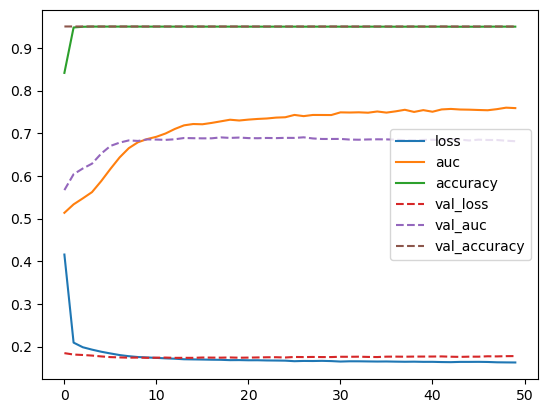

In [113]:
# Plot the training losses
metrics = [
    'loss',
    'auc',
    'accuracy']
for metric in metrics:
    plt.plot(kdd12_mlp_hist.history[metric],label=metric)

val_metrics = [f'val_{x}' for x in metrics]

for metric in val_metrics:
    plt.plot(kdd12_mlp_hist.history[metric],label=metric,linestyle='--')

plt.legend()
plt.show()

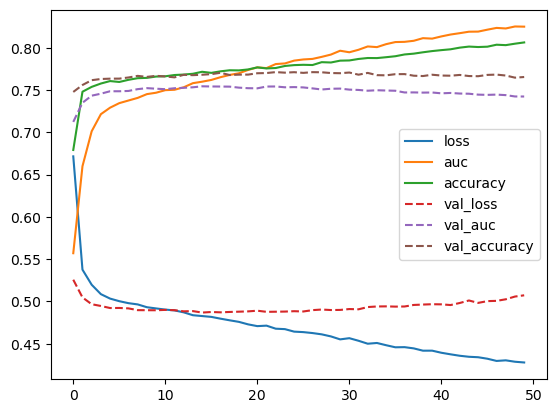

In [114]:
# Plot the training losses
metrics = [
    'loss',
    'auc',
    'accuracy']
for metric in metrics:
    plt.plot(criteo_mlp_hist.history[metric],label=metric)

val_metrics = [f'val_{x}' for x in metrics]

for metric in val_metrics:
    plt.plot(criteo_mlp_hist.history[metric],label=metric,linestyle='--')

plt.legend()
plt.show()

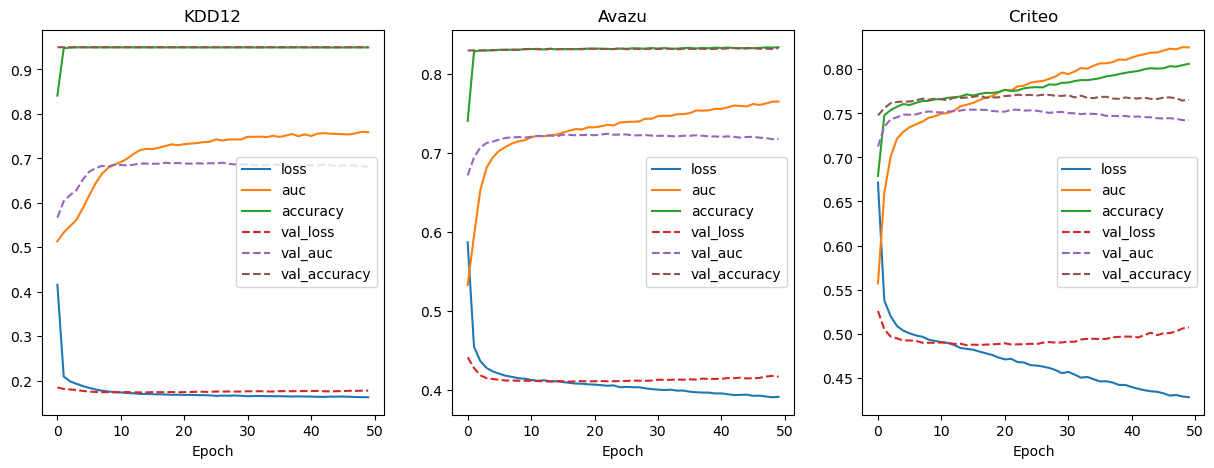

In [124]:
# Plot the training and validation losses for the three datasets
hist_objs = [
    kdd12_mlp_hist.history,
    avazu_mlp_hist.history,
    criteo_mlp_hist.history
]

datasets = ['KDD12', 'Avazu', 'Criteo']

fig, ax = plt.subplots(1,3, figsize=(15,5))
metrics = [
    'loss',
    'auc',
    'accuracy']
val_metrics = [f'val_{x}' for x in metrics]

for i in range(3):
    for metric in metrics:
        ax[i].plot(hist_objs[i][metric],label=metric)
    for metric in val_metrics:
        ax[i].plot(hist_objs[i][metric],label=metric,linestyle='--')
    ax[i].set_title(datasets[i])
    ax[i].set_xlabel('Epoch')
    ax[i].legend()
fig.savefig('figures/mlp_training_metrics.png')
fig.show()

In [125]:
# Print the maximum validation metrics for the three datasets
print("KDD12:")
kdd12_mlp.evaluate(kdd12_val_tfd)
print("\nAvazu:")
avazu_mlp.evaluate(avazu_val_tfd)
print("\nCriteo:")
criteo_mlp.evaluate(criteo_val_tfd)


KDD12:
200/200 [==============================] - 0s 2ms/step - loss: 0.1779 - accuracy: 0.9500 - auc: 0.6812

Avazu:
200/200 [==============================] - 0s 2ms/step - loss: 0.4166 - accuracy: 0.8327 - auc: 0.7176

Criteo:
200/200 [==============================] - 0s 2ms/step - loss: 0.5073 - accuracy: 0.7653 - auc: 0.7423


[0.5072792768478394, 0.7653499841690063, 0.7423076629638672]

# Summary of findings

# Suggested Future Research

<a class="anchor" id="references"></a>

# References

<a class="anchor" id="eMarketer"></a>

- eMarketer. (2023). Digital advertising spending worldwide from 2021 to 2027 (in billion U.S. dollars) . Statista. Statista Inc.. Accessed: June 09, 2024. https://www-statista-com.iclibezp1.cc.ic.ac.uk/statistics/237974/online-advertising-spending-worldwide/

<a class="anchor" id="kdd12"></a>

- Aden, Yi Wang. (2012). KDD Cup 2012, Track 2. Kaggle. https://kaggle.com/competitions/kddcup2012-track2

<a class="anchor" id="avazu"></a>

- Steve Wang, Will Cukierski. (2014). Click-Through Rate Prediction. Kaggle. https://kaggle.com/competitions/avazu-ctr-prediction

<a class="anchor" id="criteo"></a>

- Jean-Baptiste Tien, joycenv, Olivier Chapelle. (2014). Display Advertising Challenge. Kaggle. https://kaggle.com/competitions/criteo-display-ad-challenge

<a class="anchor" id="vanBuuren"></a>

- Van Buuren, S. (2018). Flexible imputation of missing data. CRC press.